In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from os import listdir
from os.path import isdir, join
from PIL import Image
import matplotlib.pyplot as plt

# Configuration
class Config:
    DATASET_PATH = "UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    SINGLE_TEST_PATH = "UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032"
    BATCH_SIZE = 8
    EPOCHS = 3
    MODEL_PATH = "model_lstm.pth"
    EARLY_STOPPING_PATIENCE = 5  # Stop if validation loss doesn't improve for 5 epochs


In [38]:
def simple_progress_bar(iteration, total, bar_length=50):
    progress = (iteration / total)
    arrow = '-' * int(round(progress * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    print('\r[{}] {}/{} ({:.2f}%)'.format(arrow + spaces, iteration, total, progress * 100), end='')


In [39]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 128 X 128
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips, 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 128, 128, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips



def get_training_set():
    clips = []
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((128, 128))  # Reduced image size
                    img = np.array(img, dtype=np.float32) / 128.0
                    all_frames.append(img)
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return np.array(clips)  # Convert list to numpy array before tensor conversion


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor




In [41]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_size + hidden_size, 4 * hidden_size, kernel_size, 1, self.padding)

    def forward(self, x, state):
        h_cur, c_cur = state
        combined = torch.cat([x, h_cur], dim=1)
        gates = self.conv(combined)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        c_next = (forgetgate * c_cur) + (ingate * cellgate)
        h_next = outgate * torch.tanh(c_next)

        return h_next, c_next
    
    def initialize_hidden_state(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_size, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_size, height, width, device=self.conv.weight.device))



In [42]:
class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self._all_layers = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_size if i == 0 else self.hidden_size
            cell = ConvLSTMCell(input_size=cur_input_dim,
                                hidden_size=self.hidden_size,
                                kernel_size=self.kernel_size)
            self._all_layers.append(cell)
            self.add_module('cell_{}'.format(i), cell)

    def forward(self, x, hidden_state=None):
        internal_state = []
        outputs = []
        for step in range(x.size(1)):
            x_t = x[:, step, :, :, :]
            for i in range(self.num_layers):
                # get or initialize the internal state
                if hidden_state is None:
                    h, c = self._all_layers[i].initialize_hidden_state(batch_size=x_t.size(0), image_size=(x_t.size(2), x_t.size(3)))
                else:
                    h, c = hidden_state[i]
                h, c = self._all_layers[i](x_t, [h, c])
                x_t = h
                if i == (self.num_layers - 1):
                    outputs.append(h)
            internal_state.append([h, c])

        layer_output = torch.stack(outputs, dim=1)
        return layer_output, internal_state



In [43]:
class AnomalyDetectionModel(nn.Module):
    def __init__(self):
        super(AnomalyDetectionModel, self).__init__()
        # Encoder
        self.encoder_time_distributed_conv1 = nn.Conv2d(1, 128, kernel_size=11, stride=4, padding=5)
        self.encoder_time_distributed_conv2 = nn.Conv2d(128, 64, kernel_size=5, stride=2, padding=2)
        self.encoder_conv_lstm1 = ConvLSTM(64, 64, kernel_size=3, num_layers=1)
        self.encoder_conv_lstm2 = ConvLSTM(64, 32, kernel_size=3, num_layers=1)
        self.encoder_conv_lstm3 = ConvLSTM(32, 64, kernel_size=3, num_layers=1)

        # Decoder
        self.decoder_time_distributed_conv_transpose1 = nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.decoder_time_distributed_conv_transpose2 = nn.ConvTranspose2d(64, 128, kernel_size=11, stride=4, padding=2, output_padding=1)
        self.decoder_time_distributed_conv3 = nn.Conv2d(128, 1, kernel_size=10, padding=3)



    def forward(self, x):
        # Reshape to handle time distributed operations
        b, t, h, w, c = x.size()
        x = x.view(b*t, c, h, w)
        
        # Encoder
        x = self.encoder_time_distributed_conv1(x)
        
        x = self.encoder_time_distributed_conv2(x)
        
        # Reshape for LSTM layers
        x = x.view(b, t, x.size(1), x.size(2), x.size(3))
        
        x, _ = self.encoder_conv_lstm1(x)
        
        x, _ = self.encoder_conv_lstm2(x)
        
        x, _ = self.encoder_conv_lstm3(x)

        # Reshape for decoder conv layers
        x = x.view(b*t, x.size(2), x.size(3), x.size(4))
        
        # Decoder
        x = self.decoder_time_distributed_conv_transpose1(x)
        
        x = self.decoder_time_distributed_conv_transpose2(x)
        
        x = self.decoder_time_distributed_conv3(x)

        x = x[:, :, :128, :128]

        # Reshape back to original shape
        x = x.view(b, t, h, w, c)
        
        return x


In [44]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    best_loss = float('inf')
    stopping_counter = 0
    
    for epoch in range(Config.EPOCHS):
        epoch_loss = 0.0
        for sequences in train_loader:
            sequences = sequences.to(device)
            optimizer.zero_grad()
            b, t, h, w, c = sequences.size()
            sequences_reshaped = sequences.view(b*t, c, h, w)
            outputs = model(sequences)
            loss = criterion(outputs.view(b*t, c, h, w), sequences_reshaped)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{Config.EPOCHS}], Loss: {avg_epoch_loss:.4f}")

        # Early stopping based on training loss
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(model.state_dict(), Config.MODEL_PATH)
            stopping_counter = 0
        else:
            stopping_counter += 1
            if stopping_counter == Config.EARLY_STOPPING_PATIENCE:
                print("Early stopping triggered.")
                break

def get_model(reload_model=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AnomalyDetectionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    if reload_model:
        model.load_state_dict(torch.load(Config.MODEL_PATH))
        model.eval()
    else:
        training_set = get_training_set()
        training_set = torch.tensor(training_set).float()
        # DataLoader with num_workers
        train_loader = DataLoader(training_set, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4)  # num_workers set to 4
        train_model(model, train_loader, optimizer, criterion, device)
        torch.save(model.state_dict(), Config.MODEL_PATH)

    return model


def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 128, 128, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((128, 128))
            img = np.array(img, dtype=np.float32) / 128.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

import matplotlib.pyplot as plt


# Update evaluate function to use PyTorch for model prediction
def evaluate_batchwise(model, sequences, batch_size):
    reconstructed_sequences_list = []
    for i in range(0, sequences.size(0), batch_size):
        with torch.no_grad():
            batch = sequences[i:i+batch_size]
            reconstructed_batch = model(batch)
            reconstructed_sequences_list.append(reconstructed_batch)
    return torch.cat(reconstructed_sequences_list, dim=0)

def evaluate():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(True).to(device)
    test = get_single_test()
    test = torch.tensor(np.array(test)).float().to(device)

    sz = test.size(0) - 10 + 1
    sequences = torch.zeros(sz, 10, 128, 128, 1).to(device)
    for i in range(sz):
        sequences[i] = test[i:i+10].to(device)

    reconstructed_sequences = evaluate_batchwise(model, sequences, batch_size=10)

    sequences_reconstruction_cost = torch.sqrt(torch.sum((sequences - reconstructed_sequences) ** 2, dim=[2,3,4]))

    sa = (sequences_reconstruction_cost - torch.min(sequences_reconstruction_cost)) / torch.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    plt.plot(sr.cpu().numpy())
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()



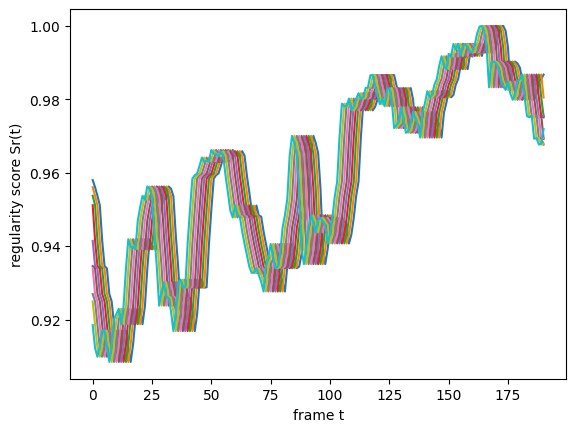

In [45]:

# Call evaluate to test the converted code
evaluate()